### Extract the dataset and split accordingly

- Unzip the dataset
- Split the dataset into train, validation and test sets
- From the metadata build the train, validation and test images and labels folders
- Load the Images from directory

In [8]:
import zipfile
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import helper_funcs as helper
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import json
from pathlib import Path


import warnings
warnings.filterwarnings('ignore')

# model analysis and development
import edgeimpulse as ei
import livelossplot
from livelossplot import PlotLossesKeras 


# Set random seed for reproducibility
random_state = 42
# tf.random.set_seed(random_state)
# random.seed(random_state)

In [ ]:
# Extract the dataset to the current working directory
with zipfile.ZipFile('./dataset.zip', 'r') as zip:
    zip.extractall(f'{os.getcwd()}')

In [ ]:
# load the train and test metadata
data_dir = os.path.join(os.getcwd(), 'dataset')
train_metadata_path = os.path.join(data_dir, 'train.csv')
test_metadata_path = os.path.join(data_dir, 'test.csv')

# read the data
train_df = pd.read_csv(train_metadata_path)
test_df = pd.read_csv(test_metadata_path)

# split the train set to train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# the length of all the sets
sets_len = len(train_df) + len(val_df) + len(test_df)

# print the length of each set
print(f'Train set length: {len(train_df)}, {len(train_df)/sets_len*100:.2f}%')
print(f'Validation set length: {len(val_df)}, {len(val_df)/sets_len*100:.2f}%')
print(f'Test set length: {len(test_df)}, {len(test_df)/sets_len*100:.2f}%')

Train set length: 1668, 71.83%
Validation set length: 418, 18.00%
Test set length: 236, 10.16%


In [ ]:
# build the image datasets
train_dir = os.path.join(data_dir, 'train') # location of the training data
val_dir = os.path.join(data_dir, 'train') # location of the validation data
test_dir = os.path.join(data_dir, 'test') # location of the test data

# create the training, validation and test directories
helper.split_data(train_dir, train_df, 'train')
helper.split_data(val_dir, val_df, 'val')
helper.split_data(test_dir, test_df, 'test')

In [6]:
# load the images to tensors 
train_images_path = 'train'
val_images_path = 'val'
test_images_path = 'test'

train_tensors = tf.keras.preprocessing.image_dataset_from_directory(
                                                                    'train',
                                                                    image_size=(96, 96),
                                                                    batch_size=6,
                                                                    shuffle=True
                                                                )
val_tensors = tf.keras.preprocessing.image_dataset_from_directory(
                                                                    'val',
                                                                    image_size=(96, 96),
                                                                    batch_size=6
                                                                )
test_tensors = tf.keras.preprocessing.image_dataset_from_directory(
                                                                    'test',
                                                                    image_size=(96, 96),
                                                                    batch_size=6
                                                                )

# extract the train images and labels
train_images, train_labels = helper.extract_images_and_labels(train_tensors, normalize=True)

# extract the validation images and labels
val_images, val_labels = helper.extract_images_and_labels(val_tensors, normalize=True)

# extract the test images and labels
test_images, test_labels = helper.extract_images_and_labels(test_tensors, normalize=True)

# Define the labels dictionary
labels = {
    0: 'BUSHBUCK',
    1: 'IMPALA',
    2: 'MONKEY',
    3: 'WARTHOG',
    4: 'WATERBUCK',
    5: 'ZEBRA'
}

# categeorical
# train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=6)
# val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=6)
# test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=6)

Found 1668 files belonging to 6 classes.
Found 418 files belonging to 6 classes.
Found 236 files belonging to 6 classes.


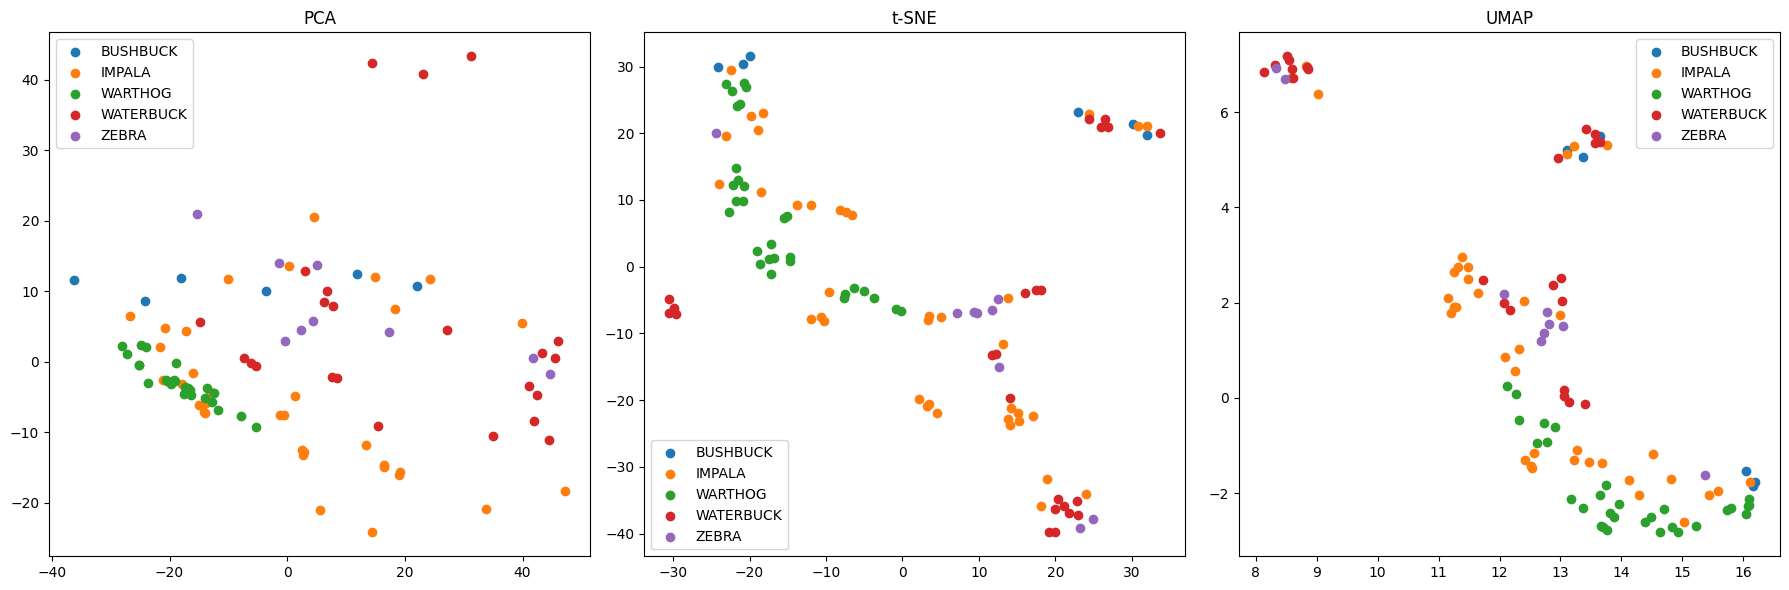

In [22]:
# Call the function with your train_images, train_labels, and labels
helper.visualize_dimensionality_reduction(train_images, train_labels, labels)


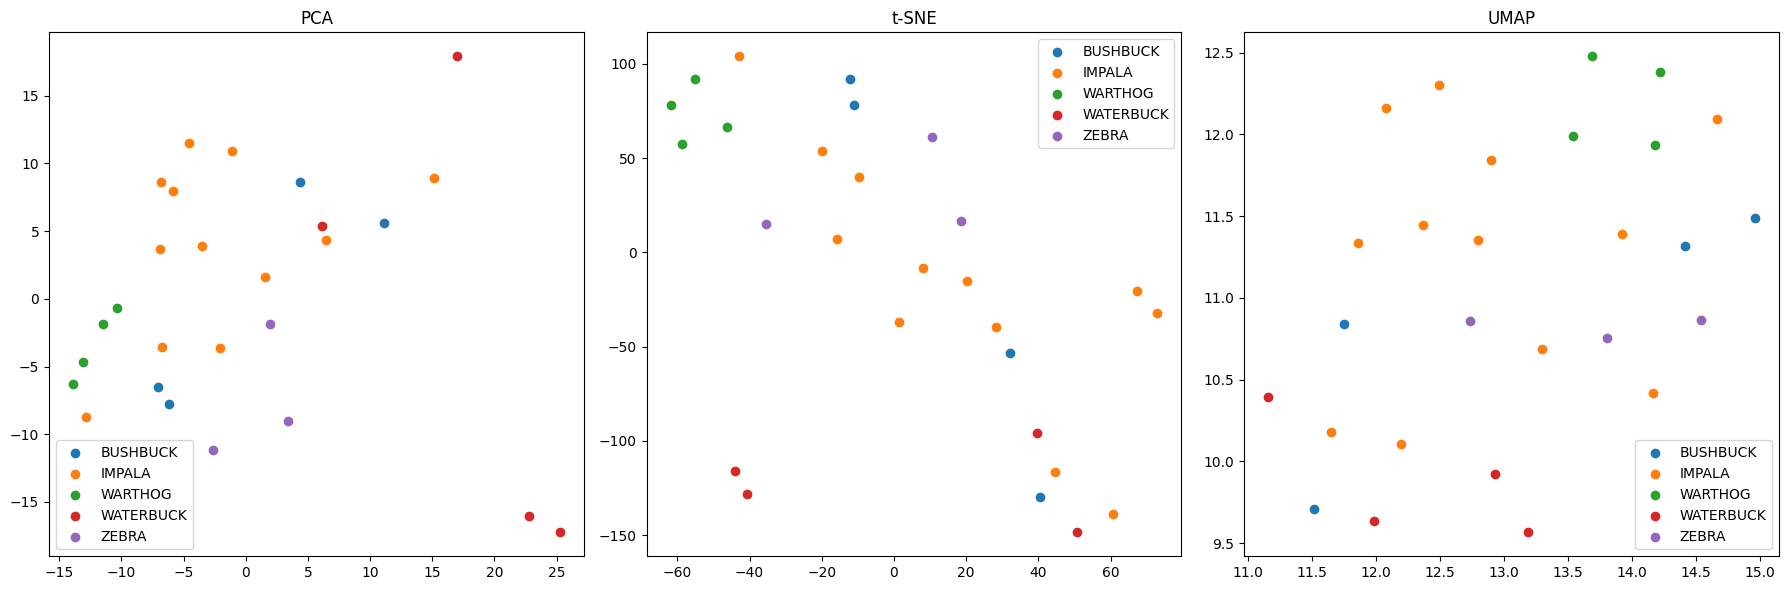

In [6]:
helper.visualize_dimensionality_reduction(val_images, val_labels, labels)


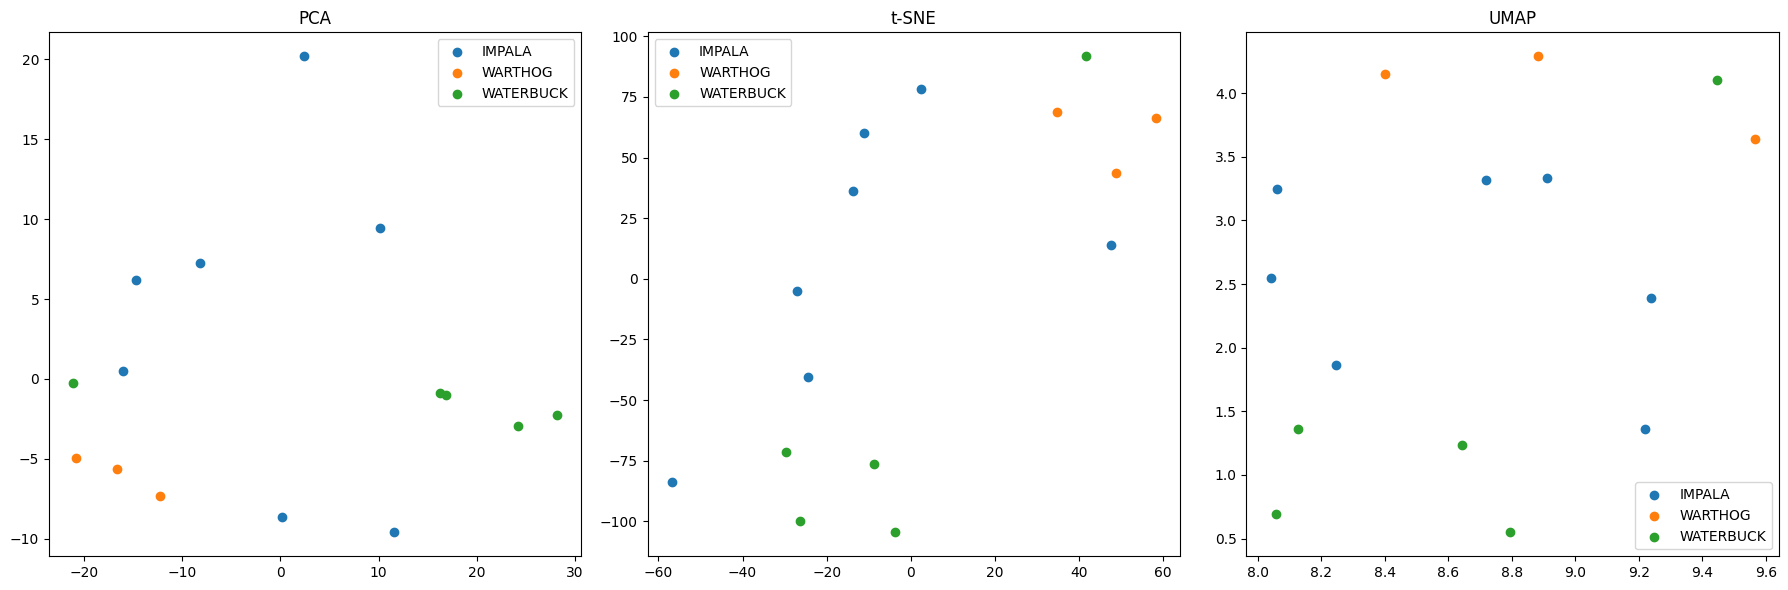

In [7]:
helper.visualize_dimensionality_reduction(test_images, test_labels, labels, perplexity=5)


### Enrich the dataset

- Generate synthetic data
- Data augmentation

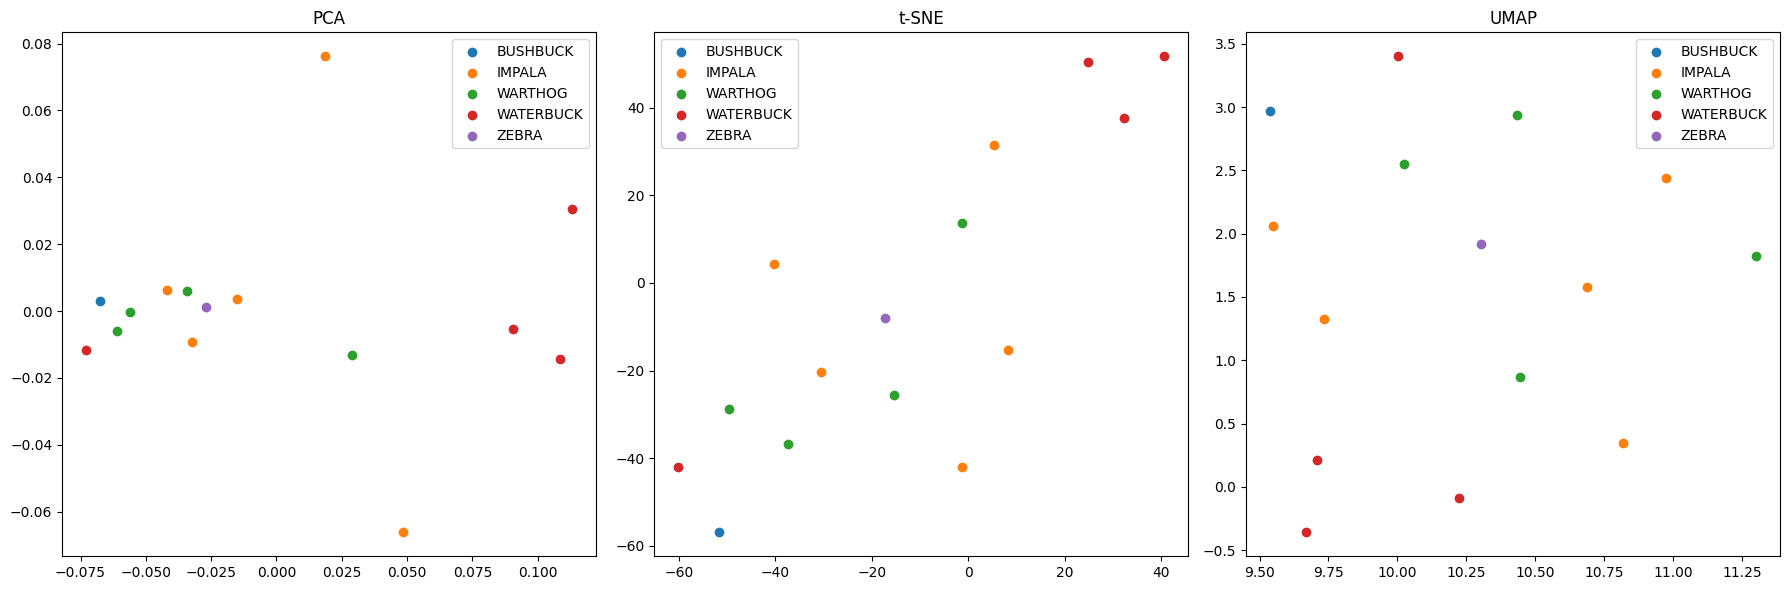

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

# Your data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    preprocessing.Rescaling(1.0/255.0),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomContrast(0.2),
    preprocessing.RandomFlip("horizontal_and_vertical"),
    preprocessing.RandomTranslation(0.2, 0.2),
    
])

# Apply data augmentation directly within the map function
augmented_train_data = test_tensors.map(lambda x, y: (data_augmentation(x), y))

augmented_train_images, augmented_train_labels = helper.extract_images_and_labels(augmented_train_data)


# Now you can visualize or further process augmented_train_images and augmented_train_labels
helper.visualize_dimensionality_reduction(augmented_train_images, augmented_train_labels, labels, perplexity=5)


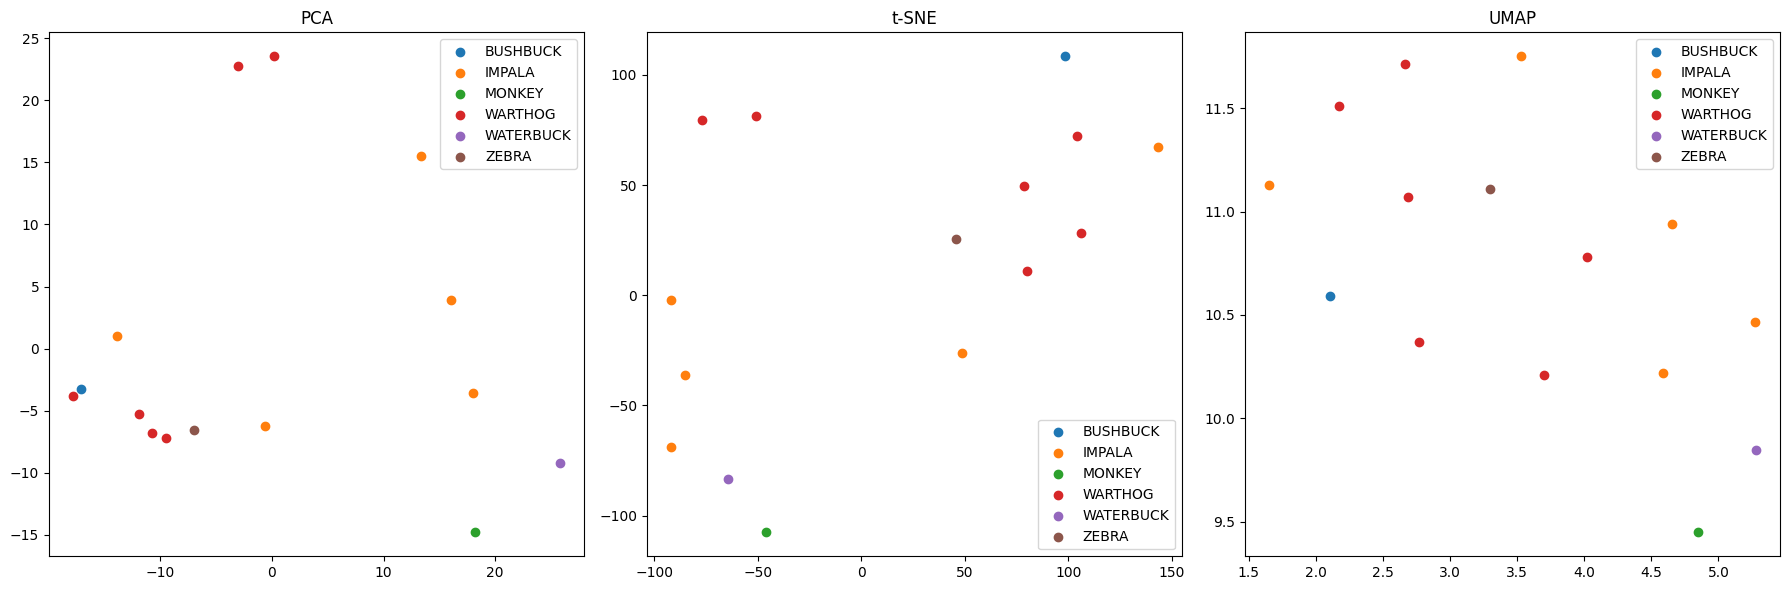

In [ ]:
helper.visualize_dimensionality_reduction(test_images, test_labels, labels, perplexity=5)


In [ ]:
train_tensors

<_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

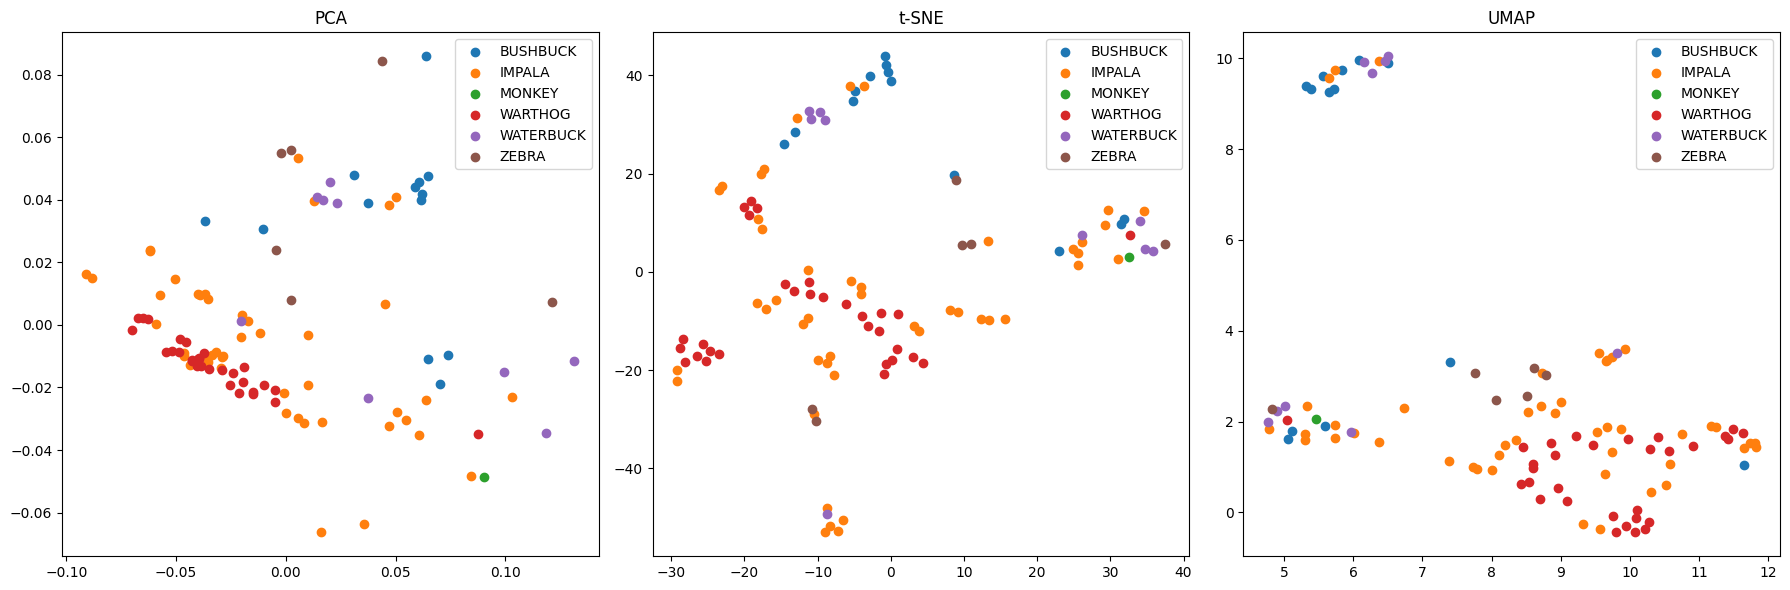

In [ ]:
helper.visualize_dimensionality_reduction(augmented_train_images, augmented_train_labels, labels)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

# Your data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    preprocessing.Rescaling(1.0/255.0),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomContrast(0.2),
])

# Load and preprocess the datasets
train_tensors = tf.keras.preprocessing.image_dataset_from_directory(
    'train',
    image_size=(64, 64),
    batch_size=16,
    shuffle=True
)

# Count the occurrences of each class in the dataset
class_counts = np.bincount(train_tensors.labels)

# Calculate the inverse class frequencies for balancing
class_frequencies = 1.0 / class_counts

# Calculate the sampling weights based on class frequencies
sampling_weights = np.take(class_frequencies, train_tensors.labels)

# Define a function to apply data augmentation with class imbalance
def augment_data(images, labels, weights):
    augmented_images = data_augmentation(images)
    return augmented_images, labels, weights

# Create a dataset with augmented data and sampling weights
augmented_train_data = tf.data.Dataset.from_tensor_slices((train_tensors, sampling_weights))
augmented_train_data = augmented_train_data.map(augment_data)

# Shuffle and batch the augmented data
batch_size = 16
augmented_train_data = augmented_train_data.shuffle(buffer_size=len(train_tensors))
augmented_train_data = augmented_train_data.batch(batch_size)

# Continue with your training process using the augmented_train_data


Found 1668 files belonging to 6 classes.


AttributeError: '_BatchDataset' object has no attribute 'labels'

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Your data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    preprocessing.Rescaling(1.0/255.0),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomContrast(0.2),
])

# Load and preprocess the datasets
train_tensors = tf.keras.preprocessing.image_dataset_from_directory(
    'train',
    image_size=(64, 64),
    batch_size=16,
    shuffle=True
)

# Extract images and labels from train_tensors
train_images = np.concatenate([images for images, _ in train_tensors], axis=0)
train_labels = np.concatenate([labels for _, labels in train_tensors], axis=0)

# Apply data augmentation to the entire dataset
augmented_train_images = data_augmentation(train_images)

# Create an instance of RandomOverSampler for oversampling
oversampler = RandomOverSampler(random_state=42)
oversampled_images, oversampled_labels = oversampler.fit_resample(
    augmented_train_images, train_labels
)

# Create an instance of RandomUnderSampler for undersampling
undersampler = RandomUnderSampler(random_state=42)
balanced_images, balanced_labels = undersampler.fit_resample(
    oversampled_images, oversampled_labels
)

# Create a TensorFlow dataset from the balanced data
balanced_train_dataset = tf.data.Dataset.from_tensor_slices(
    (balanced_images, balanced_labels)
).shuffle(buffer_size=len(balanced_labels)).batch(16)


Found 1668 files belonging to 6 classes.


ValueError: Found array with dim 4. None expected <= 2.

### Model Development

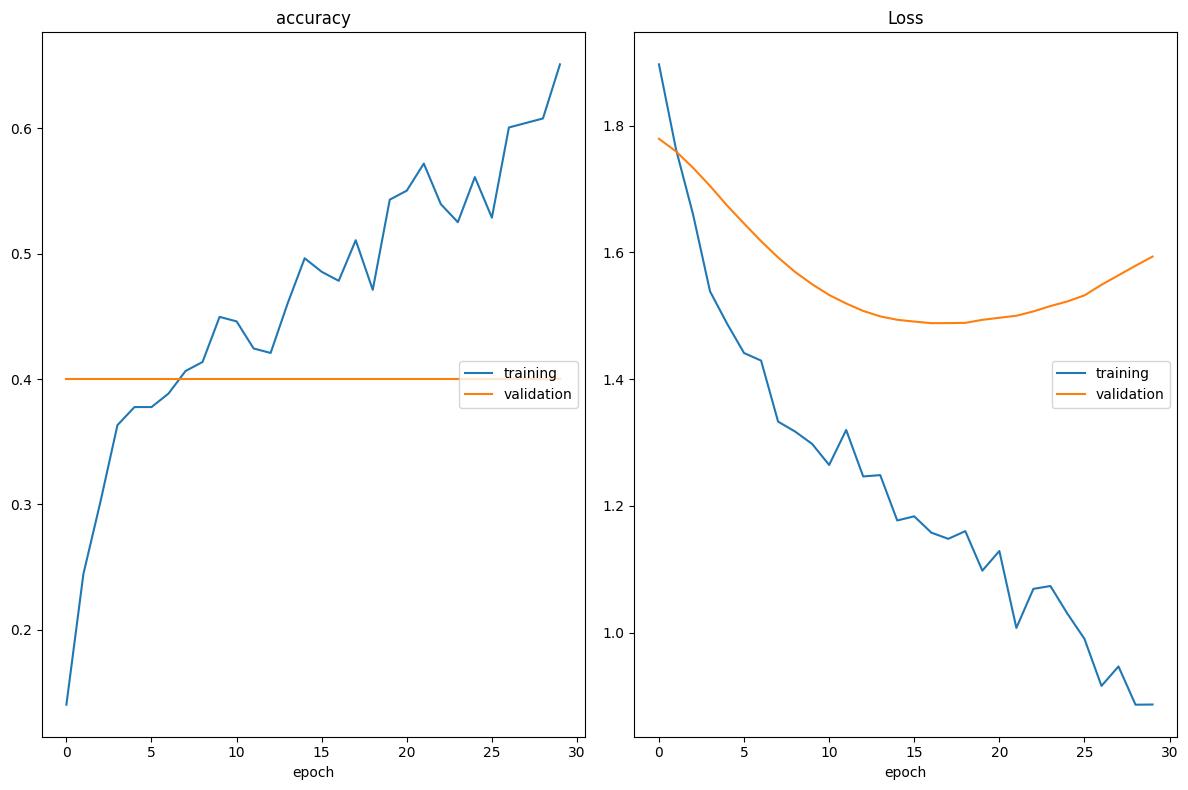

accuracy
	training         	 (min:    0.140, max:    0.651, cur:    0.651)
	validation       	 (min:    0.400, max:    0.400, cur:    0.400)
Loss
	training         	 (min:    0.887, max:    1.897, cur:    0.887)
	validation       	 (min:    1.488, max:    1.779, cur:    1.593)
9/9 - 2s - loss: 0.8869 - accuracy: 0.6511 - val_loss: 1.5933 - val_accuracy: 0.4000 - 2s/epoch - 206ms/step


In [7]:
model = tf.keras.applications.mobilenet.MobileNet(
    input_shape=(96, 96, 3),
    alpha=0.1,
    dropout=0.1,
    weights=None,
    pooling='avg',
    classes=6,
)

model.summary()
EPOCHS = 30
LEARNING_RATE = 0.0005


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,
                                                 weight_decay=0.00),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

filepath = 'mobileweights_6classes.h5'

# Define the ModelCheckpoint callback
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, mode='min', verbose=2)

history = model.fit(
                  train_images,
                  train_labels,
                  epochs=EPOCHS,
                  validation_data=(val_images, val_labels),
                  verbose=2,
                  callbacks=[checkpoint, PlotLossesKeras()]
                )


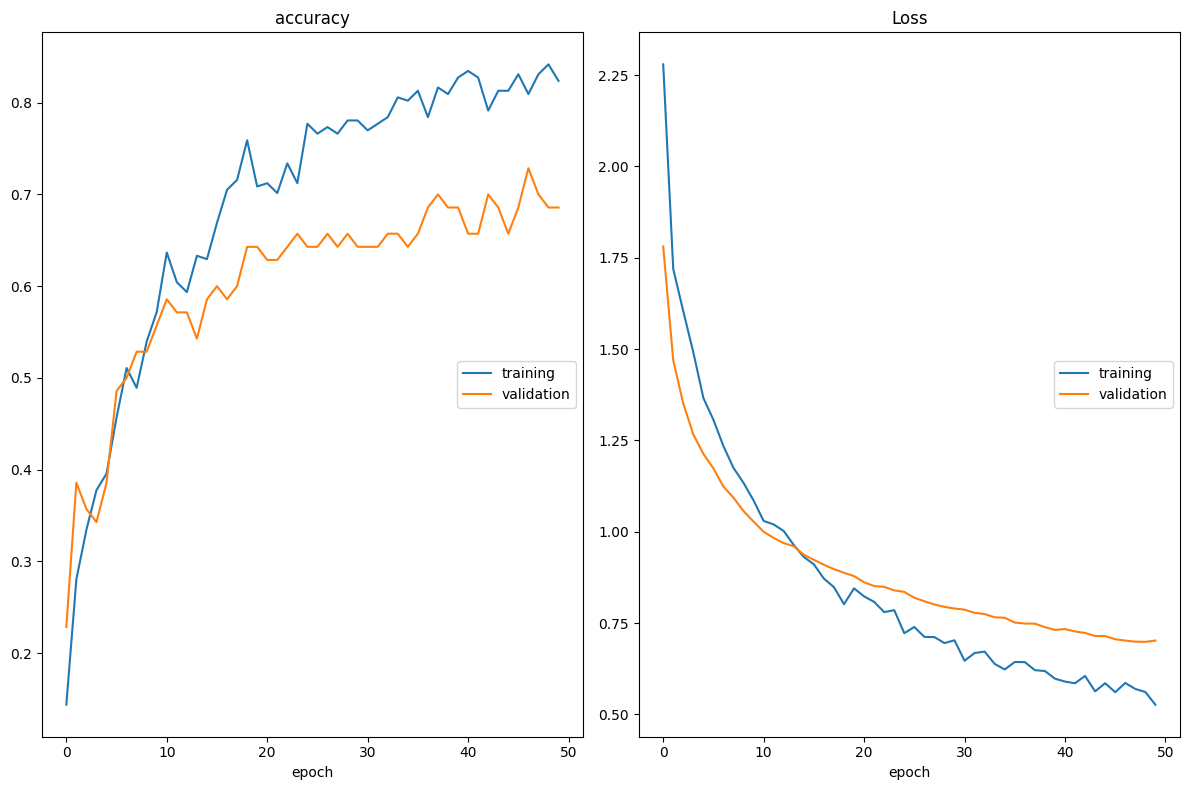

accuracy
	training         	 (min:    0.144, max:    0.842, cur:    0.824)
	validation       	 (min:    0.229, max:    0.729, cur:    0.686)
Loss
	training         	 (min:    0.527, max:    2.279, cur:    0.527)
	validation       	 (min:    0.699, max:    1.781, cur:    0.702)
9/9 - 2s - loss: 0.5266 - accuracy: 0.8237 - val_loss: 0.7021 - val_accuracy: 0.6857 - 2s/epoch - 189ms/step


In [32]:
transfer_weights = os.path.join(Path(os.getcwd()).parent, 'models', 'weights', 'MobileNetV1.0_2.96x96.color.bsize_96.lr_0_05.epoch_170.val_loss_3.61.val_accuracy_0.27.hdf5')
base_model = tf.keras.applications.MobileNet(input_shape=(96,96,3),
                                weights=transfer_weights,
                                alpha=0.2
                                )

base_model.trainable = False

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(96,96,3), name='x_input'))
# Don't include the base model's top layers
last_layer_index = -5
model.add(tf.keras.Model(inputs=base_model.inputs, outputs=base_model.layers[last_layer_index].output))
model.add(tf.keras.layers.GlobalAveragePooling2D())  # Global average pooling
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(6, activation='softmax'))
model.summary()


EPOCHS = 50
LEARNING_RATE = 0.001


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,
                                                 weight_decay=0.00),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

filepath = 'mobileweights_6classes.h5'

# Define the ModelCheckpoint callback
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, mode='min', verbose=2)

history = model.fit(
                  train_images,
                  train_labels,
                  epochs=EPOCHS,
                  validation_data=(val_images, val_labels),
                  verbose=2,
                  callbacks=[checkpoint, PlotLossesKeras()]
                )


## Model Evaluation

In [37]:
model.evaluate(test_images, test_labels)

2/2 [==============================] - 1s 34ms/step - loss: 0.8681 - accuracy: 0.7500


[0.8681498765945435, 0.75]

In [40]:
from sklearn.metrics import classification_report

test_images, test_labels = helper.extract_images_and_labels(test_tensors, normalize=True, categorical=False)
y_pred = model.predict(test_images, batch_size=6, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(test_labels, y_pred_bool))

7/7 [==============================] - 0s 17ms/step
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.68      0.85      0.76        20
           3       0.67      0.67      0.67         9
           4       0.00      0.00      0.00         4
           5       0.50      0.50      0.50         2

    accuracy                           0.65        40
   macro avg       0.57      0.48      0.50        40
weighted avg       0.64      0.65      0.62        40



7/7 [==============================] - 0s 15ms/step


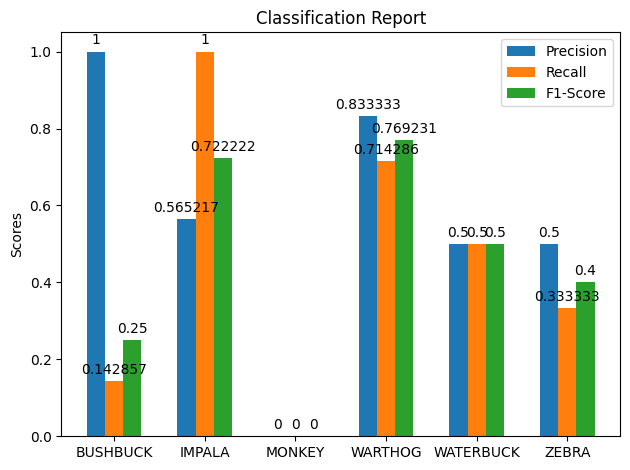

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Assuming you already have these variables defined
test_images, test_labels = helper.extract_images_and_labels(test_tensors, normalize=True, categorical=False)
y_pred = model.predict(test_images, batch_size=6, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

# Generate classification report
report = classification_report(test_labels, y_pred_bool, output_dict=True)

# Extract class names and metrics from the report
class_names = [str(label) for label in list(report.keys())[:-3]]  # Exclude 'macro avg', 'weighted avg', etc.
precision = []
recall = []
f1_score = []

for label in class_names:
    try:
        precision.append(report[label]['precision'])
    except KeyError:
        precision.append(0)  # Handle missing precision with a default value
        
    try:
        recall.append(report[label]['recall'])
    except KeyError:
        recall.append(0)  # Handle missing recall with a default value
        
    try:
        f1_score.append(report[label]['f1-score'])
    except KeyError:
        f1_score.append(0)  # Handle missing F1-score with a default value

# Create a bar plot using Matplotlib
x = np.arange(len(class_names))
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1-Score')

ax.set_ylabel('Scores')
ax.set_title('Classification Report')
ax.set_xticks(x)
ax.set_xticklabels([labels[int(label)] for label in class_names])  # Using custom class labels
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()


## Model Quantization

In [33]:
# load the best model
model = tf.keras.models.load_model('mobileweights_6classes.h5')

# quantizing the model to float16
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

hub_m = converter.convert()

# save the keras model
with open('mobileweights_6classes.tflite', 'wb') as f:
  f.write(hub_m)

INFO:tensorflow:Assets written to: C:\Users\Austin\AppData\Local\Temp\tmpic354v72\assets


INFO:tensorflow:Assets written to: C:\Users\Austin\AppData\Local\Temp\tmpic354v72\assets


In [34]:
import edgeimpulse as ei
# add the api key to edge impulse
with open('config.json') as f:
    config = json.load(f)


api_key = config['edge_impulse_api_key']
ei.API_KEY = api_key
    
# the supported devices
profile_devices = ei.model.list_profile_devices()

# target device is open mv cam h7 plus
model_profile = ei.model.profile(model=hub_m, device='arduino-nicla-vision')

In [36]:
model_profile.summary()

Target results for float32:
{
    "device": "arduino-nicla-vision",
    "tfliteFileSizeBytes": 202952,
    "isSupportedOnMcu": false,
    "timePerInferenceMs": 6773,
    "mcuSupportError": "edge-impulse-sdk/tensorflow/lite/micro/kernels/fully_connected.cc Hybrid models are not supported on TFLite Micro.\nNode FULLY_CONNECTED (number 33f) failed to prepare with status 1\n"
}


Performance on device types:
{
    "variant": "float32",
    "lowEndMcu": {
        "description": "Estimate for a Cortex-M0+ or similar, running at 40MHz",
        "timePerInferenceMs": 995595,
        "memory": {},
        "supported": false,
        "mcuSupportError": "edge-impulse-sdk/tensorflow/lite/micro/kernels/fully_connected.cc Hybrid models are not supported on TFLite Micro.\nNode FULLY_CONNECTED (number 33f) failed to prepare with status 1\n"
    },
    "highEndMcu": {
        "description": "Estimate for a Cortex-M7 or other high-end MCU/DSP, running at 240MHz",
        "timePerInferenceMs": 13546,
   

## Model Deployment

In [63]:
# a target list of hardware for deployment
target_list = ei.model.list_deployment_targets()

# generating an output file for the arduino nano 33 ble sense
ei.model.deploy(model="mobileweights_6classes.tflite",
                model_output_type=ei.model.output_type.Classification(),
                deploy_target='arduino-nano-33-ble-sense',
                output_directory=".")

In [67]:
# a target list of hardware for deployment
target_list = ei.model.list_deployment_targets()

# generating an output file for the arduino nano 33 ble sense
ei.model.deploy(model="mobileweights_6classes.tflite",
                model_output_type=ei.model.output_type.Classification(),
                deploy_target='meta-tf',
                output_directory=".")

In [62]:
target_list = ei.model.list_deployment_targets()
target_list

['zip',
 'arduino',
 'cubemx',
 'wasm',
 'wasm-browser-simd',
 'tensorrt',
 'ethos',
 'synaptics-tensaiflow-lib',
 'meta-tf',
 'memryx-dfp',
 'tidl-lib-am62a',
 'slcc',
 'arduino-nano-33-ble-sense',
 'arduino-nicla-vision',
 'espressif-esp32',
 'raspberry-pi-rp2040',
 'silabs-xg24',
 'infineon-cy8ckit-062s2',
 'infineon-cy8ckit-062-ble',
 'nordic-thingy53',
 'renesas-ck-ra6m5',
 'brickml',
 'runner-linux-aarch64',
 'runner-linux-armv7',
 'runner-linux-x86_64',
 'runner-linux-aarch64-akd1000',
 'runner-linux-x86_64-akd1000',
 'runner-mac-x86_64',
 'runner-linux-aarch64-tda4vm',
 'runner-linux-aarch64-am62a',
 'particle']